# <h1><center><span style="color:blue">Finger</span></center></h1>

**Author:**  Camille Le Scao <br>
**Contact:**  camille.le-scao@etu.u-paris.fr <br>
**Date:**  01/04/2020 <br>
**Last updated:** 26/09/2023 <br>
**Version:**  Python 3.9.12 <br>

## INITIATION

### Charge librairies

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
import tables
import h5py   
import pickle

### Vein Class

In [3]:
class VeinArray:
    
    def __init__(self,index,x0,y0,t0,level,mother_index): 
        self.index=index
        self.array=np.zeros((3,1))
        self.array[0,0]=x0
        self.array[1,0]=y0
        self.array[2,0]=t0
        self.level=level
        self.mother_index=mother_index
        
    def add_point(self,x,y,t):
        col=np.array([[x],[y],[t]])
        self.array=np.append(self.array,col,axis=1)
        
    def del_point(self,i):
        self.array=np.delete(self.array,i,axis=1)

In [4]:
class VeinJunction:
    
    def __init__(self,time,array,level,mother_index):
        self.array=array
        self.time=time
        self.level=level
        self.mother_index=mother_index

### Define Parameters

#### default parameters

In [5]:
np.random.seed(0)

In [6]:
NB_POINTS_0 = 150  #initial points on the front for initial_array()
L = 100  #for fixed growth function
X_AXIS = list(np.linspace(-L / 2, L / 2, NB_POINTS_0)) #initial spread on the X axis for initial_array()
D_MIN = 0.2  #a factor for the minimal distance between points
D_MAX = 2  #a factor for the maximal distance between points
MAX_RES = 1.3333333 #maximum distance between 2 points of the front to condition new point creation
MIN_RES = 0.1333333 #minimul between 2 points of the front to condition point suppression

<div class="alert alert-block alert-warning"><b>Warning:</b> In this code, the general array is a line with direction, here the initial front goes from -50 -> 50 (left to right) on the x_axis, so be careful with it as it means the front will advance eitehr to the top or the bottom. Furthemore, do be careful when comparing an arc as itial growth front to a line as considering our other functions left to right is equival to the anti-trigonometric direction </div>

#### tunable parameters

In [7]:
NB_VEINES = 6
NOISE_REDUCTION = 0  #noise on the initial points position
D_VEIN = 16.6666666  #critical distance for vein_propagation()
S_GROWTH = 16.6666666  #for growth_front_vein()
A0 = 0  #to tune minimal growth for growth functions
AM = 1 #to tune vein dependant growth for growth function
DT = 0.05
T = 50000

In [8]:
print(f"'D_VEIN' parameter must be close {X_AXIS[-1]*2/NB_VEINES} in distance units")
print(f"'S_GROWTH' parameter is tuned comparatively to D_VEIN")
print(f"'MIN_RES' is the minimum distance between points and must be close to {X_AXIS[-1]*2*D_MIN/NB_POINTS_0} in distance units")
print(f"'MAX_RES' is the maximum distance between points and must be close to {X_AXIS[-1]*2*D_MAX/NB_POINTS_0} in distance units")
print(f"'L' parameter must be close to {abs(max(X_AXIS)) + abs(min(X_AXIS))} in distance units")

'D_VEIN' parameter must be close 16.666666666666668 in distance units
'S_GROWTH' parameter is tuned comparatively to D_VEIN
'MIN_RES' is the minimum distance between points and must be close to 0.13333333333333333 in distance units
'MAX_RES' is the maximum distance between points and must be close to 1.3333333333333333 in distance units
'L' parameter must be close to 100.0 in distance units


### Functions A: create initial growth_front

In [9]:
def initial_array_line(nb_points_0 = NB_POINTS_0, noise_reduction = NOISE_REDUCTION, x_axis = X_AXIS, nb_veins = NB_VEINES):
    
    first_array = np.zeros((10,nb_points_0))
    first_array[8,:] = np.nan
    index = 0
    
    for x_coordinate in x_axis:
        first_array[0,index] = (x_coordinate + np.random.normal() * noise_reduction)
        index += 1
        
    first_array, list_veins, list_junctions = initiate_veins(first_array, nb_veins)
    
    first_array = distance_array(first_array)
    first_array = vecteur_normal_corrected(first_array)
    first_array = curvature_corrected(first_array)
    
    print(f"The first array is done")
    return(first_array, list_veins, list_junctions)

In [10]:
def initial_array_arc(noise_reduction = NOISE_REDUCTION, nb_points = NB_POINTS_0, R = X_AXIS[-1]):
    first_array = np.zeros((10,nb_points))
    theta = np.linspace(3 * np.pi / 2, 0, nb_points, )
    for i in range(0,len(theta)):
        theta[i] = theta[i] + np.random.normal() * noise_reduction
    first_array[0,:] = R * (1 + np.cos(theta))
    first_array[1,:] = R * np.sin(theta)
    
    first_array = distance_array(first_array)
    first_array = vecteur_normal_corrected(first_array)
    first_array = curvature_corrected(first_array)    
    
    return(first_array)

In [ ]:
def initial_array_halfcircle(noise_reduction = NOISE_REDUCTION, nb_points = NB_POINTS_0, R = X_AXIS[-1], nb_veins = NB_VEINES):
    
    first_array = np.zeros((10,nb_points))
    first_array[8,:] = np.nan
    
    theta = np.linspace(np.pi, 0, nb_points)
    for i in range(0,len(theta)):
        theta[i] = theta[i] + np.random.normal() * noise_reduction
    first_array[0,:] = R * (1 + np.cos(theta)) - R
    first_array[1,:] = (R * np.sin(theta) ) / 2
    
    first_array, list_veins, list_junctions = initiate_veins(first_array, nb_veins)
    
    first_array = distance_array(first_array)
    first_array = vecteur_normal_corrected(first_array)
    first_array = curvature_corrected(first_array)    
    
    return(first_array, list_veins, list_junctions)

In [ ]:
def initial_array_halfcircle_inversed(noise_reduction = NOISE_REDUCTION, nb_points = NB_POINTS_0, R = X_AXIS[-1], nb_veins = NB_VEINES):
    
    first_array = np.zeros((10,nb_points))
    first_array[8,:] = np.nan
    
    theta = np.linspace(np.pi, 2 * np.pi, nb_points)
    for i in range(0,len(theta)):
        theta[i] = theta[i] + np.random.normal() * noise_reduction
    first_array[0,:] = R * (1 + np.cos(theta)) - R
    first_array[1,:] = (R * np.sin(theta) - R) / 2 + R / 2
    
    first_array, list_veins, list_junctions = initiate_veins(first_array, nb_veins)
    
    first_array = distance_array(first_array)
    first_array = vecteur_normal_corrected(first_array)
    first_array = curvature_corrected(first_array)    
    
    return(first_array, list_veins, list_junctions)

In [11]:
def initiate_veins(first_array, nb_veins):
    
    # Initiate
    
    veins_index = []
    list_veins = []
    list_junctions = []
    
    # Determine and veins index and add in first array
    
    nb_points = first_array.shape[1]
    for vein in range(nb_veins):
        index = int(nb_points*(vein+1) / (nb_veins+1))
        veins_index.append(index)
        first_array[8,index] = vein  
    first_array[7,veins_index] = 1
    
    # Initiate vein in class/list_veins
    
    for vein in range(len(veins_index)):
        #vein(self, index, x0, y0, t0, level, mother_index, weight)
        v = VeinArray(vein,first_array[0,veins_index[vein]],first_array[1,veins_index[vein]],0,0,np.nan)
        list_veins.append(v)  
        
    print(f"Veins were created")
    return(first_array,list_veins,list_junctions)


### Functions B: calibrate growth_front parameters

In [12]:
def distance_array(growth_front):
    
    growth_front[2,0] = 0
    for point in range(1,growth_front.shape[1]):
        growth_front[2,point] = math.sqrt((growth_front[0,point] - growth_front[0,point-1])**2 + (growth_front[1,point] - growth_front[1,point-1])**2) 
        
    return(growth_front)

In [13]:
def vecteur_normal_corrected(growth_front): 
    #divided the value by 2, except at the border
    
    #first point
    
    growth_front[3,0] = growth_front[1,1] - growth_front[1,0]  #u
    growth_front[4,0] = - growth_front[0,1] + growth_front[0,0]  #v
    Lo = math.sqrt(growth_front[3,0]**2 + growth_front[4,0]**2)  #normalized
    growth_front[3,0] = growth_front[3,0] / Lo
    growth_front[4,0] = growth_front[4,0] / Lo
    
    #front Loop
    
    for point in range(1,growth_front.shape[1] - 1):
            growth_front[3,point] = (growth_front[1,point+1] - growth_front[1,point-1]) / 2  #have to divide the distance by two
            growth_front[4,point] = (-growth_front[0,point+1] + growth_front[0,point-1]) / 2
            Lo = math.sqrt(growth_front[3,point]**2 + growth_front[4,point]**2)  #normalized
            growth_front[3,point] = growth_front[3,point] / Lo
            growth_front[4,point] = growth_front[4,point] / Lo   
            
    #Last point
    
    growth_front[3,-1] = growth_front[1,-1] - growth_front[1,-2]
    growth_front[4,-1] = -growth_front[0,-1] + growth_front[0,-2]
    Lo = math.sqrt(growth_front[3,-1]**2 + growth_front[4,-1]**2)  #normalized
    growth_front[3,-1] = growth_front[3,-1] / Lo
    growth_front[4,-1] = growth_front[4,-1] / Lo
    
    # Warning, for the direction (inside or outside)
    
    growth_front[4,:] = - growth_front[4,:]
    growth_front[3,:] = - growth_front[3,:]
    
    return(growth_front)

In [14]:
def curvature_corrected(growth_front): 
    
    # first point
    u_1 = growth_front[3,0]
    v_1 = growth_front[4,0]
    u_2 = growth_front[3,1]
    v_2 = growth_front[4,1]
    corr = 1 / 2
    d = growth_front[2,1] * corr
    growth_front[9,0] = math.asin(u_1 * v_2 - u_2 * v_1) / d
    
    # second point
    u_1 = growth_front[3,0]
    v_1 = growth_front[4,0]
    u_2 = growth_front[3,2]
    v_2 = growth_front[4,2]
    corr = 3 / 4
    d = (growth_front[2,1] + growth_front[2,2]) * corr
    growth_front[9,1] = math.asin(u_1 * v_2 - u_2 * v_1) / d    
    
    
    # loop     
    for point in range(2,growth_front.shape[1] - 2):
        u_1 = growth_front[3,point-1]
        v_1 = growth_front[4,point-1]
        u_2 = growth_front[3,point+1]
        v_2 = growth_front[4,point+1]
        d = growth_front[2,point+1] + growth_front[2,point]             
        growth_front[9,point] = math.asin(u_1 * v_2 - u_2 * v_1) / d
    
    # first before last
    u_1 = growth_front[3,-3]
    v_1 = growth_front[4,-3]
    u_2 = growth_front[3,-1]
    v_2 = growth_front[4,-1]
    corr = 3 / 4
    d = (growth_front[2,-1] + growth_front[2,-2]) * corr
    growth_front[9,-2] = math.asin(u_1 * v_2 - u_2 * v_1) / d  
    
    # last point
    v_1=growth_front[3,-1]
    u_1=growth_front[4,-1]
    v_2=growth_front[3,-2]
    u_2=growth_front[4,-2]
    corr = 1 / 2
    d = growth_front[2,-1] * corr
    growth_front[9,-1] = math.asin(u_1 * v_2 - u_2 * v_1) / d 
    
    return(growth_front)

### Functions C: growth functions

<div class="alert alert-block alert-info"><b>Info:</b> 
There are several type of growth functions presented here: <br>
- growth_frond_const() is a function in which the growth is constant <br>
- growth_vein_dependant() is a function in which the growt is centered on the the position of veins <br>
- growth_frond_obstacle(), associated with angle_pol() to compute the integral of angle between a point and all point of a front, is a function for which front overlap corresponding points are deleted (not like in the wood removal code)
    
</div>

In [15]:
def growth_frond_const(growth_front):
    
    gf_deepcopy = deepcopy(growth_front) 
    A_L=0.2
    gf_deepcopy[0,:] = gf_deepcopy[0,:] + A_L * growth_front[3,:]
    gf_deepcopy[1,:] = gf_deepcopy[1,:] + A_L * growth_front[4,:]
    
    gf_deepcopy = distance_array(gf_deepcopy)
    gf_deepcopy = vecteur_normal_corrected(gf_deepcopy)
    gf_deepcopy = curvature_corrected(gf_deepcopy)   
    
    return(gf_deepcopy)

In [16]:
def growth_frond_finger(growth_front, dt = DT, l = L):
    
    gf_deepcopy = deepcopy(growth_front) 
    A_L = (1 + np.cos(2 * math.pi * growth_front[0,:] / l)) * dt / 2
    gf_deepcopy[0,:] = gf_deepcopy[0,:] + A_L * growth_front[3,:]
    gf_deepcopy[1,:] = gf_deepcopy[1,:] + A_L * growth_front[4,:]
    
    gf_deepcopy = distance_array(gf_deepcopy)
    gf_deepcopy = vecteur_normal_corrected(gf_deepcopy)
    gf_deepcopy = curvature_corrected(gf_deepcopy)   
    
    return(gf_deepcopy)

In [17]:
def growth_vein_dependant(growth_front, a0 = A0, am = AM, s_growth = S_GROWTH , d_vein = D_VEIN, dt = DT):
    
    #Copy initial array
    next_growth_front = deepcopy(growth_front)  

    #Dependant Growth
    veins = np.nonzero(growth_front[7,:] == 1)[0]
    s = np.cumsum(growth_front[2,:])

    delta_var = np.zeros(next_growth_front.shape[1]) + a0
    for j in veins:   
        dj = s - s[j]
        A_j = am * np.exp(-(dj**2) / (s_growth**2))
        delta_var += A_j
        #plt.plot(delta_var)  #check if error in growth
    delta_var = delta_var * (s_growth / d_vein)  # Normalized

    # Compute x and y
    next_growth_front[0,:] = growth_front[0,:] + (delta_var * dt) * growth_front[3,:]
    next_growth_front[1,:] = growth_front[1,:] + (delta_var * dt) * growth_front[4,:]
    
    next_growth_front = distance_array(next_growth_front)
    next_growth_front = vecteur_normal_corrected(next_growth_front)
    next_growth_front = curvature_corrected(next_growth_front)  
  
    return(next_growth_front)

In [18]:
def angle_pol(x_old,y_old,x_new,y_new,ind):
    
    # INSIDE POINT COORDINATES
    x_ins = x_new[ind]
    y_ins = y_new[ind]

    ## SUM OF ANGLES

    # loop angles
    sum_angle=0
    for i in range(len(x_old)):
        if i == len(x_old)-1:
            vector1_x  = x_old[i] - x_ins
            vector1_y = y_old[i] - y_ins

            vector2_x = x_old[0] - x_ins
            vector2_y = y_old[0] - y_ins

            angle = math.atan2( vector1_x*vector2_y - vector1_y*vector2_x, vector1_x*vector2_x + vector1_y*vector2_y)
            sum_angle += angle
        else: 
            vector1_x = x_old[i] - x_ins
            vector1_y = y_old[i] - y_ins

            vector2_x = x_old[i+1] - x_ins
            vector2_y = y_old[i+1] - y_ins

            angle = math.atan2( vector1_x*vector2_y - vector1_y*vector2_x, vector1_x*vector2_x + vector1_y*vector2_y)
            sum_angle += angle
 
    return(sum_angle/math.pi)

In [19]:
def growth_vein_obstacle(growth_front, a0 = A0, am = AM, s_growth = S_GROWTH , d_vein = D_VEIN, dt = DT):
    
    #Copy initial array
    old_front = deepcopy(growth_front)
    next_growth_front = deepcopy(growth_front)  

    #Dependant Growth
    veins = np.nonzero(growth_front[7,:] == 1)[0]
    s = np.cumsum(growth_front[2,:])

    delta_var = np.zeros(next_growth_front.shape[1]) + a0
    for j in veins:   
        dj = s - s[j]
        A_j = am * np.exp(-(dj**2) / (s_growth**2))
        delta_var += A_j
        #plt.plot(delta_var)  #check if error in growth
    delta_var = delta_var * (s_growth / d_vein)  # Normalized

    # Compute x and y
    next_growth_front[0,:] = growth_front[0,:] + (delta_var * dt) * growth_front[3,:]
    next_growth_front[1,:] = growth_front[1,:] + (delta_var * dt) * growth_front[4,:]
    
    #  find overlap and restore
    
    ind_toremove = []
    for i in range(1, old_front.shape[1] - 1):
        angle_i = angle_pol(old_front[0,:], old_front[1,:], next_growth_front[0,:], next_growth_front[1,:], i)
        if (angle_i > 0.1) or (angle_i < -0.1):
            ind_toremove.append(i)
            
            
    next_growth_front = np.delete(next_growth_front, ind_toremove, axis = 1)
    
    
    next_growth_front = distance_array(next_growth_front)
    next_growth_front = vecteur_normal_corrected(next_growth_front)
    next_growth_front = curvature_corrected(next_growth_front)  
  
    return(next_growth_front)

In [20]:
def growth_vein_obstacle_combined(growth_front, a0 = A0, am = AM, s_growth = S_GROWTH , d_vein = D_VEIN, dt = DT, l = L):
    
    # copy initial array
    old_front = deepcopy(growth_front)
    next_growth_front = deepcopy(growth_front)  

    # dependant Growth
    veins = np.nonzero(growth_front[7,:] == 1)[0]
    s = np.cumsum(growth_front[2,:])

    delta_var = np.zeros(next_growth_front.shape[1]) + a0
    for j in veins:   
        dj = s - s[j]
        A_j = am * np.exp(-(dj**2) / (s_growth**2))
        delta_var += A_j
        #plt.plot(delta_var)  #check if error in growth
    delta_var = delta_var * (s_growth / d_vein)  #  normalized
    
    # fixed growth
    delta_fixed = 1 + np.cos(2 * math.pi * growth_front[0,:] / L)
    delta_fixed = delta_fixed * (L / d_vein)  #  normalized

    # compute x and y
    next_growth_front[0,:] = growth_front[0,:] + (delta_var * 2 + delta_fixed) * dt * growth_front[3,:]
    next_growth_front[1,:] = growth_front[1,:] + (delta_var * 2 + delta_fixed) * dt * growth_front[4,:]
    
    #  find overlap and restore
    
    ind_toremove = []
    for i in range(1, old_front.shape[1] - 1):
        angle_i = angle_pol(old_front[0,:], old_front[1,:], next_growth_front[0,:], next_growth_front[1,:], i)
        if (angle_i > 0.1) or (angle_i < -0.1):
            ind_toremove.append(i)
            
            
    next_growth_front = np.delete(next_growth_front, ind_toremove, axis = 1)
    
    
    next_growth_front = distance_array(next_growth_front)
    next_growth_front = vecteur_normal_corrected(next_growth_front)
    next_growth_front = curvature_corrected(next_growth_front)  
  
    return(next_growth_front)

### Functions D: growth_front resolution 

In [21]:
def insert_points(growth_front, max_res = MAX_RES):
    
    if growth_front.shape[1] < 10000:  #maximum size
        insert = np.nonzero(growth_front[2,:] > max_res)[0]
        growth_front[5,:] = 0
        if len(insert) != 0:
            col = np.zeros((growth_front.shape[0], len(insert)))
            for j in range(0, len(insert)):
                col[0,j] = (growth_front[0,insert[j]] + growth_front[0,insert[j]-1]) / 2
                col[1,j] = (growth_front[1,insert[j]] + growth_front[1,insert[j]-1]) / 2
                col[5,j] = 1
            growth_front = np.insert(growth_front, insert[:], col, axis = 1)
            
    growth_front = distance_array(growth_front)
    growth_front = vecteur_normal_corrected(growth_front)
    growth_front = curvature_corrected(growth_front) 
 
    return(growth_front)

In [22]:
def delete_points(growth_front, min_res = MIN_RES):
    
    delete = np.nonzero((growth_front[2,:] < min_res) & (growth_front[7,:] == 0))[0]
    
    while len(delete) > 1:  #reminder: after a test, you showed you were deleting too many points if using directly np.delete
        growth_front = np.delete(growth_front,delete[1], axis = 1)
        growth_front = distance_array(growth_front)
        delete = np.nonzero((growth_front[2,:] < min_res) & (growth_front[7,:] == 0))[0] #delete point by point
        
    growth_front = distance_array(growth_front)
    growth_front = vecteur_normal_corrected(growth_front)
    growth_front = curvature_corrected(growth_front) 
    
    return(growth_front)

### Functions E: loops

<div class="alert alert-block alert-warning"><b>Warning:</b> Deleting two more neighbours in case does not work. By looking at all neighbours instead of of a minimal number defined by MAX_SPREAD / MINIMUM_DISTANCE_BETWEEN_POINTS, we limit the number of loops, but do not supress them completely </div>

In [23]:
def loop_removal(old_front, new_front, iteration):
    
    #  create matrix with x and y coordinates
    old_mat = np.array([old_front[0,:], old_front[1,:]])
    new_mat = np.array([new_front[0,:], new_front[1,:]])
    
    #  compute the list of distance bewteen a point and itself at t + 1, find max spread to consider
    spread_list = np.sqrt(np.sum((new_mat - old_mat)**2, axis = 0))
    max_spread = max(spread_list)
    d_points = min(new_front[2,1:])  #the distance at the first point is zero
    #neighbours = math.ceil(2 * max_spread / d_points)
    neighbours = old_front.shape[1]
    
    #  create and fill distance matrice, lines: (size 2*neighbours + 1), columns: (number of points columns)
    #  each lines correspond to the distance between all the points of the front and the neighbour k
    dist_mat = np.zeros((2 * neighbours + 1, np.shape(new_mat)[1]))
    for k in range(-neighbours, neighbours + 1):
        old_mat_rolled = np.roll(old_mat, k)
        dist_mat[neighbours + k] = np.sqrt(np.sum((new_mat - old_mat_rolled)**2, axis = 0))
        
    if iteration % 100 == 0:
        print('dist mat dimensions', dist_mat.ndim)
        print('min dist_mat:', dist_mat.min())
        print('max dist_mat:', dist_mat.max())
        print('mean dist_mat', dist_mat.mean())
        print('std dist_mat', np.std(dist_mat))
        print('spread_list dimension', spread_list.ndim)
        print('min spread_list', spread_list.min())
        print('max spread_list', spread_list.max())
        print('mean spread list', spread_list.mean())
        print('std spread list', np.std(spread_list))
    
    #  delete a point of the new front if there is 
    #  at least one point for which the distance is inferior to the spread of the point
    
    ind_toremove = np.unique((dist_mat < spread_list[None,:]).nonzero()[1])
    
    #  now delete it
    cleaned_front = np.delete(new_front, ind_toremove, axis = 1)
    
    #  compute other parameters to give clean array
    cleaned_front = distance_array(cleaned_front)
    cleaned_front = vecteur_normal_corrected(cleaned_front)
    cleaned_front = curvature_corrected(cleaned_front) 
    
    return(cleaned_front)

### Functions F: vein propagation

In [24]:
def propagate_veins_regular(growth_front, list_veins, list_junctions, iteration_time, d_vein = D_VEIN):
 
    ##  DELETE PREVIOUS JUNCTIONS

    erease = np.nonzero(growth_front[7,:] > 1)[0]
    growth_front[7,erease] = 0

    ##  COMPUTE DISTANCES BETWEEN VEINS
    
    distance = 0
    for point in range(growth_front.shape[1]): 
        
        #  no vein
        
            if growth_front[7,point] == 0:
                distance = distance + growth_front[2,point]
                growth_front[6,point] = distance 
        
        #  vein          
        
            elif growth_front[7,point] == 1:
                distance = distance + growth_front[2,point]
                growth_front[6,point] = distance
                distance = 0
                
    ##  VEIN CREATION
    
    veins = np.nonzero(growth_front[7,:] == 1)[0]  #  find all veins
    
    #  if a single vein, we take into account the distance to the edge
    
    if len(veins) <= 1:
        v0 = 0
        v1 = veins[0]
        v2 = -1

        #  critical distance rule
         
        if growth_front[6,v1] + growth_front[6,v2] >= 2 * d_vein:
            growth_front[7,v1] = 0
            third_1 = int(v0 + 2*(v1 - v0) / 3)
            third_2 = int(v1 + (v2 - v1) / 3)    
            growth_front[7,third_1] = 1
            growth_front[7,third_2] = 1
            growth_front[8,third_1] = len(list_veins)
            growth_front[8,third_2] = len(list_veins) + 1
            growth_front[7,third_1+1:third_2-1] = 2
            
            #  new vein in list_veins     
            
            mother_index = int(growth_front[8,v1])
            level = list_veins[mother_index].level+1
            v_third_1 = VeinArray(len(list_veins), growth_front[0,third_1], growth_front[1,third_1], iteration_time, level, int(growth_front[8,v1]))
            v_third_2 = VeinArray(len(list_veins) + 1, growth_front[0,third_2], growth_front[1,third_2], iteration_time, level, int(growth_front[8,v1]))
            list_veins.append(v_third_1)
            list_veins.append(v_third_2)           
             
            #  junctions creation
            
            array_junction = growth_front[0:2,third_1+1:third_2-1]
            link = VeinJunction(iteration_time, array_junction, level, mother_index)
            list_junctions.append(link)
            third_1 = None
            third_2 = None
            
    #  if multiple veins
        
    else:
            for vein_index in range(0,len(veins)):
                
                if vein_index == 0:  
                    v0 = 0
                    v1 = veins[vein_index]
                    v2 = veins[vein_index+1]
                    
                elif vein_index == len(veins) - 1:
                    v0 = veins[vein_index-1]
                    v1 = veins[vein_index]
                    v2 = growth_front.shape[1] - 1
                    
                else: 
                    v0 = veins[vein_index-1]
                    v1 = veins[vein_index]
                    v2 = veins[vein_index+1]
            
                #  critical distance rule
                
                if growth_front[6,v1] + growth_front[6,v2] >= 2 * d_vein:
                    growth_front[7,v1] = 0
                    third_1 = int(v0+2*(v1-v0)/3)
                    third_2 = int(v1+(v2-v1)/3)
                    growth_front[7,third_1] = 1
                    growth_front[7,third_2] = 1
                    growth_front[8,third_1] = len(list_veins)
                    growth_front[8,third_2] = len(list_veins)+1
                    growth_front[7,third_1+1:third_2-1] = 2
            
                #  new vein in list_veins      
                
                    mother_index = int(growth_front[8,v1])
                    level = list_veins[mother_index].level + 1
                    v_third_1 = VeinArray(len(list_veins), growth_front[0,third_1], growth_front[1,third_1], iteration_time, level, int(growth_front[8,v1]))
                    v_third_2 = VeinArray(len(list_veins) + 1, growth_front[0,third_2], growth_front[1,third_2], iteration_time, level, int(growth_front[8,v1]))
                    list_veins.append(v_third_1)
                    list_veins.append(v_third_2)
            
                #  junctions creation
            
                    array_junction = growth_front[0:2,third_1+1:third_2-1]
                    link = VeinJunction(iteration_time, array_junction, level, mother_index)
                    list_junctions.append(link)
                    third_1 = None
                    third_2 = None
        
 ## PROPAGATE VEINS
    where_veins = np.where(growth_front[7,:] == 1)[0]
    
    for v in where_veins:
        list_veins[int(growth_front[8,v])].add_point(growth_front[0,v], growth_front[1,v], iteration_time)
     
    
    return(growth_front, list_veins, list_junctions)

## TEST

In [25]:
first_front = initial_array_line()[0]
print(f"Veins position are {np.where(first_front[7,:] == 1)[0]}")

Veins were created
The first array is done
Veins position are [ 21  42  64  85 107 128]


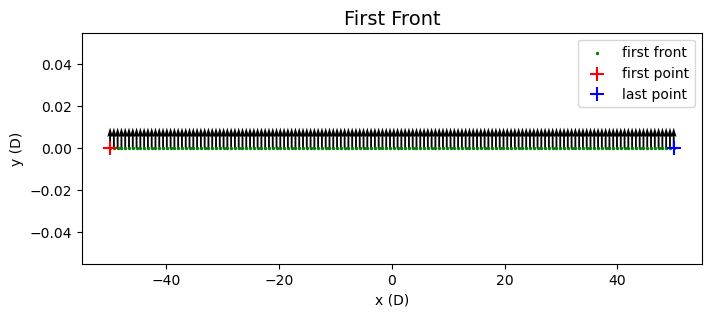

In [26]:
%matplotlib inline
title = "First Front" 
fig, ax = plt.subplots(figsize = (8,3))
plt.title(title, fontsize = 14)
ax.set(xlabel = 'x (D)', ylabel = 'y (D)')

x = first_front[0,:]
y = first_front[1,:]
u = first_front[3,:]
v = first_front[4,:]
plt.quiver(x, y, u, v, scale = 30, width = 0.003)
plt.scatter(x, y, color = "green", s = 2, label = 'first front')

x0 = first_front[0,0]
y0 = first_front[1,0]
plt.scatter(x0, y0, color = "red", s = 96, marker='+', label = 'first point')

xlast = first_front[0,-1]
ylast = first_front[1,-1]
plt.scatter(xlast, ylast, color = "blue", s = 96, marker='+', label = 'last point')

plt.legend()

plt.show()

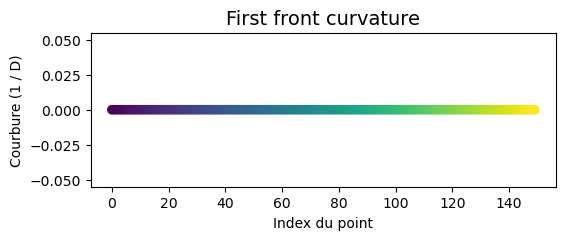

In [27]:
%matplotlib inline
title = "First front curvature" 
fig, ax = plt.subplots(figsize = (6,2))
plt.title(title, fontsize=14)
ax.set(xlabel = 'Index du point', ylabel = 'Courbure (1 / D)')
plt.grid(False)
  
c = first_front[9,:]
index = range(len(c))
plt.scatter(range(len(c)), y = c, c = index)

plt.show()

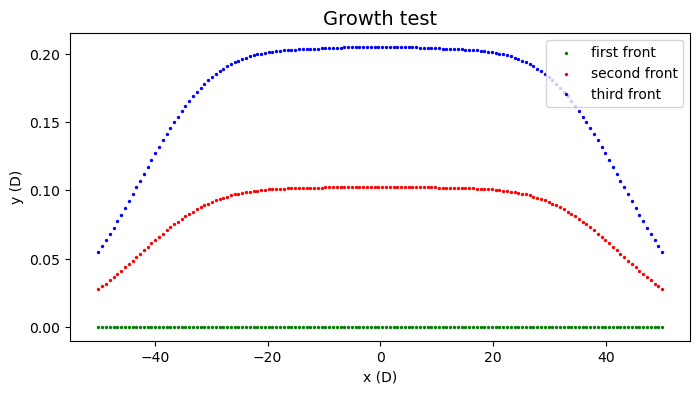

In [28]:
second_front = growth_vein_dependant(first_front)
third_front = growth_vein_dependant(second_front)

%matplotlib inline

title = "Growth test" 
fig, ax = plt.subplots(figsize = (8,4))
#plt.gca().set_aspect('equal', adjustable='box')
plt.title(title, fontsize = 14)
ax.set(xlabel = 'x (D)', ylabel = 'y (D)')

x1 = first_front[0,:]
y1 = first_front[1,:]
u1 = first_front[3,:]
v1 = first_front[4,:]
plt.scatter(x1, y1, color = "green", s = 2, label = 'first front')

x2 = second_front[0,:]
y2 = second_front[1,:]
u2 = second_front[3,:]
v2 = second_front[4,:]
#plt.quiver(x2, y2, u2, v2, scale = 30, width = 0.003)
plt.scatter(x2, y2, color = "red", s = 2, label = 'second front')

x3 = third_front[0,:]
y3 = third_front[1,:]
u3 = third_front[3,:]
v3 = third_front[4,:]
#plt.quiver(x3, y3, u3, v3, scale = 30, width = 0.003)
plt.scatter(x3, y3, color = "blue", s = 2, label = 'third front')

plt.legend()
plt.show()

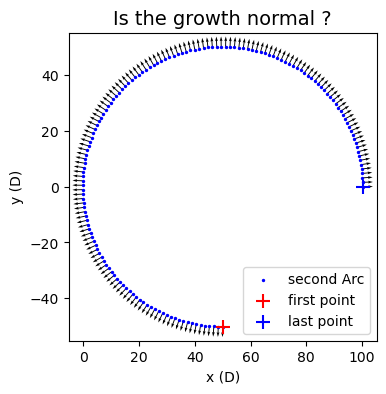

In [29]:
front_circle_initial = initial_array_arc()
front_circle_new = growth_frond_const(front_circle_initial)

%matplotlib inline

title = "Is the growth normal ?" 
fig, ax = plt.subplots(figsize = (8,4))
plt.gca().set_aspect('equal', adjustable='box')
plt.title(title, fontsize = 14)
ax.set(xlabel = 'x (D)', ylabel = 'y (D)')

x1 = front_circle_initial[0,:]
y1 = front_circle_initial[1,:]
u1 = front_circle_initial[3,:]
v1 = front_circle_initial[4,:]
#plt.quiver(x1, y1, u1, v1, scale = 30, width = 0.003)
#plt.scatter(x1, y1, color = "green", s = 2, label = 'Initial Arc')

x2 = front_circle_new[0,:]  #x
y2 = front_circle_new[1,:]  #y
u2 = front_circle_new[3,:]  #u
v2 = front_circle_new[4,:]  #v
plt.quiver(x2, y2, u2, v2, scale = 30, width = 0.003)
plt.scatter(x2, y2, color = "blue", s = 2, label = 'second Arc')

x0 = front_circle_new[0,0]
y0 = front_circle_new[1,0]
plt.scatter(x0, y0, color = "red", s = 96, marker='+', label = 'first point')

xlast = front_circle_new[0,-1]
ylast = front_circle_new[1,-1]
plt.scatter(xlast, ylast, color = "blue", s = 96, marker='+', label = 'last point')

plt.legend()
plt.show()


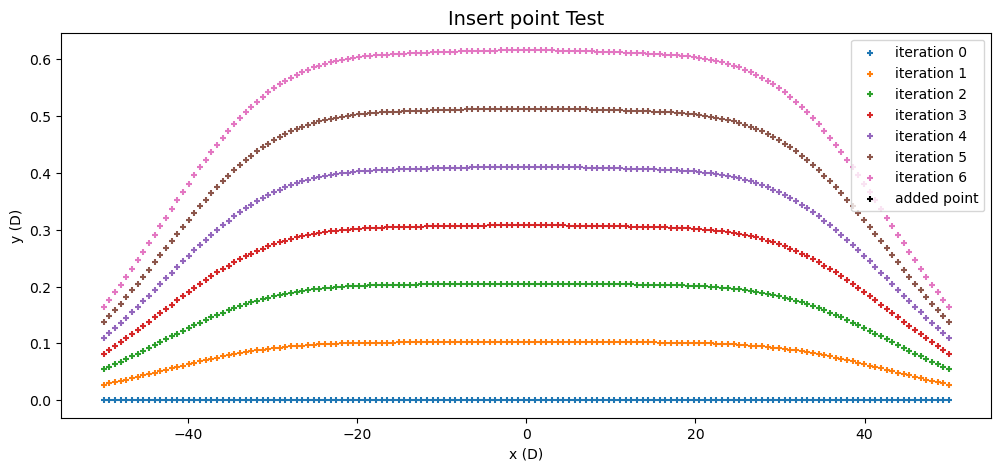

In [30]:
list_front = [first_front]

for i in range(6):
    growth_front = deepcopy(list_front[-1]) 
    growth_front = growth_vein_dependant(growth_front)
    growth_front = insert_points(growth_front)
    growth_front = vecteur_normal_corrected(growth_front)
    growth_front = curvature_corrected(growth_front)
    list_front.append(growth_front)
    
%matplotlib inline
import matplotlib.patches as mpatches

title = "Insert point Test" 
fig, ax = plt.subplots(figsize = (12,5))
#plt.gca().set_aspect('equal', adjustable='box')
plt.title(title, fontsize = 14)
ax.set(xlabel = 'x (D)', ylabel = 'y (D)')

for i in range(len(list_front)):
    growth_front = list_front[i]
    x = growth_front[0,:]
    y = growth_front[1,:]
    u = growth_front[3,:]
    v = growth_front[4,:]
    points_added = np.where(growth_front[5,:] == 1)
    #plt.quiver(x, y, u, v, scale = 30, width = 0.003)
    label = f"iteration {i}"
    plt.scatter(x, y, label = label, s = 24, marker='+')
    if i == len(list_front) - 1:
        plt.scatter(x[points_added], y[points_added], color = 'black', s = 24, marker='+', label = 'added point')
    else:
        plt.scatter(x[points_added], y[points_added], color = 'black', s = 24, marker='+')

plt.legend()
plt.show()

<div class="alert alert-block alert-warning"><b>Warning:</b> Martin's method does not work when the loop are very pointed/flat and almost tangent. In that case, yoiu have to consider all neighbours  </div>

In [31]:
# Create two Test Array

b = np.zeros((5, 21))
b[0,:] = [-0.5, -0.4, -0.3, -0.2, -0.1, -0.09, -0.07, -0.05, -0.03, -0.01, 0, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
b[1,:] = [0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5 ]


b = distance_array(b)
b = vecteur_normal_corrected(b) 

    
b2 = deepcopy(b) 
A_L=0.4
b2[0,:] = b[0,:] + A_L * b[3,:]
b2[1,:] = b[1,:] + A_L * b[4,:]
    
b2 = distance_array(b2)
b2= vecteur_normal_corrected(b2)

# Loop Removal (I copy pasted the function because the dimensions of the test array are different)

B_D_POINTS = b2[2,1:].min()

old_b2_mat = np.array([b[0,:], b[1,:]])
new_b2_mat = np.array([b2[0,:], b2[1,:]])
spread_list = np.sqrt(np.sum((new_b2_mat - old_b2_mat)**2, axis = 0))
max_spread = max(spread_list)
neighbours = math.ceil(2 * max_spread / B_D_POINTS)
dist_mat = np.zeros((2 * neighbours + 1, np.shape(new_b2_mat)[1]))

for k in range(-neighbours, neighbours + 1):
    old_b2_mat_rolled = np.roll(old_b2_mat, k)
    dist_mat[neighbours + k] = np.sqrt(np.sum((new_b2_mat - old_b2_mat_rolled)**2, axis = 0))
    
ind_toremove = np.unique((dist_mat < spread_list[None,:]).nonzero()[1])
b2_cleaned_front = np.delete(b2, ind_toremove, axis = 1)


neighbours_all = b.shape[1]
dist_mat = np.zeros((2 * neighbours_all + 1, np.shape(new_b2_mat)[1]))

for k in range(-neighbours_all, neighbours_all + 1):
    old_b2_mat_rolled = np.roll(old_b2_mat, k)
    dist_mat[neighbours + k] = np.sqrt(np.sum((new_b2_mat - old_b2_mat_rolled)**2, axis = 0))

    
ind_toremove = np.unique((dist_mat < spread_list[None,:]).nonzero()[1])
b2_cleaned_front_all = np.delete(b2, ind_toremove, axis = 1)



# Plot

%matplotlib qt

title = "Loop Ablation Test" 
fig, ax = plt.subplots(figsize = (5,5))
plt.gca().set_aspect('equal', adjustable='box')
plt.title(title, fontsize = 14)
ax.set(xlabel = 'x (D)', ylabel = 'y (D)')

plt.plot(b[0,:], b[1,:], label = "Initial Array")
plt.scatter(b[0,:], b[1,:], marker = '+', s = 96)
plt.plot(b2[0,:], b2[1,:], label = "After Growth")
plt.scatter(b2[0,:], b2[1,:], marker = '+', s = 96)
plt.plot(b2_cleaned_front[0,:], b2_cleaned_front[1,:], label = "After Loop Removal - minimal neighbours")
plt.scatter(b2_cleaned_front[0,:], b2_cleaned_front[1,:], marker = '+', s = 96)
plt.plot(b2_cleaned_front_all[0,:], b2_cleaned_front_all[1,:], label = "After Loop Removal - all neighbours")
plt.scatter(b2_cleaned_front_all[0,:], b2_cleaned_front_all[1,:], marker = '+', s = 96)


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## MAIN

In [32]:
#  Create initial array and lists

first_array,list_veins,list_junctions = initial_array_line()
list_growth_front = [first_array]
list_time = np.arange(0,T,DT) 

iteration_time = 0

level_max = 0

for iteration, current_time in enumerate(list_time):
    
    #  copy previous array
    growth_front_previous = list_growth_front[-1]
    
    #  growth on x and y 
    growth_front_current = growth_frond_finger(growth_front_previous)
    
    #  loop ablation
    #growth_front_current = loop_removal(growth_front_previous, growth_front_current, iteration)
    
    #  delete points
    growth_front_current = delete_points(growth_front_current)
    
    #  insert points
    growth_front_current = insert_points(growth_front_current)
    
    #  propagate vein
    growth_front_current, list_veins, list_junctions = propagate_veins_regular(growth_front_current, list_veins, list_junctions, current_time)
    
    #  TROUBLESHOOTING
    if 0:
        plt.figure()
        plt.plot(array_n[0,:],array_n[1,:],'+')
        plt.plot(array_m[0,:],array_m[1,:],'s')
        plt.show()
        input()
    
    #  Save growth front
    list_growth_front.append(growth_front_current)   
    
    #  Limit the number of iteration
    for vein_index in range(len(list_veins)):
        if list_veins[vein_index].level > level_max:
            level_max = list_veins[vein_index].level
    
    if iteration %1000 == 0: 
        print('iteration',iteration,current_time)
        print("level max:",level_max) 

    y_max = growth_front_current[1,:].max(axis = 0)
    
    if y_max > 500:
        print('LEVEL_MAX:',level_max)
        print('BREAK AT TIME:',current_time)
        break

        
    #if level_max >= 40:  
        #level = list_veins[mother_index].level + 1
        # list_veins[mother_index]
        #  list index out of range
        #  32 level mother index not defined ??????
    
        #print('LEVEL_MAX:',level_max)
        #print('BREAK AT TIME:',current_time)
        #break

Veins were created
The first array is done
iteration 0 0.0
level max: 0
iteration 1000 50.0
level max: 2
iteration 2000 100.0
level max: 6
iteration 3000 150.0
level max: 10
iteration 4000 200.0
level max: 13
iteration 5000 250.0
level max: 17
iteration 6000 300.0
level max: 21
iteration 7000 350.0
level max: 26
iteration 8000 400.0
level max: 30
iteration 9000 450.0
level max: 33
iteration 10000 500.0
level max: 38
LEVEL_MAX: 38
BREAK AT TIME: 500.0


In [33]:
print(f"There are {len(list_growth_front)} growth fronts in list_growth_front ")

There are 10002 growth fronts in list_growth_front 


In [34]:
print(f"The maximum number of vein divisions is {level_max}")

The maximum number of vein divisions is 38


## VISUALIZATION

In [35]:
%matplotlib qt

#  INITIATE

fig_leaf, ax = plt.subplots(figsize=(6,18))    #longueur puis hauteur
#plt.grid(True)
title = "Vein Dependant Growth, Dvein = {:.1f}, S_Growth = {:.1f}" .format(D_VEIN, S_GROWTH)
#plt.title(title, fontsize=15,pad=15)
plt.gca().set_aspect('equal', adjustable='box')
#ax.set(xlabel='x axis (Distance unit)', ylabel='y axis (Distance unit)')
#plt.axis('off')

## PLOT FRONTS
    
for growth_front in list_growth_front[::1000]:
    plt.scatter(growth_front[0,:], growth_front[1,:], color= 'yellowgreen', s = 0.8)
    
#for growth_front in list_growth_front[::1000]:
    #plt.scatter(growth_front[0,:], growth_front[1,:], color= 'darkolivegreen', s= 0.8)
    
# Plot last front
plt.scatter(list_growth_front[-1][0,:], list_growth_front[-1][1,:], color= 'yellowgreen', s= 0.7)
    
    
# PLOT VEINS

for vein in list_veins:
    plt.plot(vein.array[0,:], vein.array[1,:], color='blue')  # s=0.8
for junction in list_junctions:
    plt.plot(junction.array[0,:], junction.array[1,:], color='blue')  # s=0.8
    
# Plot central vein

# find primary vein on last level

x = X_AXIS[-1]
for i in range(len(list_veins)):
    if list_veins[i].level == level_max:
        if abs(list_veins[i].array[0,0]) < x:
            x = abs(list_veins[i].array[0,0])
            x_index = list_veins[i].index

            
# plot primary vein

l = level_max
x_ind = int(list_veins[x_index].index)
while l > 0:
    x1 = list_veins[x_ind].array[0,:]
    y1 = list_veins[x_ind].array[1,:]
    x0_ind = int(list_veins[x_ind].mother_index)
    x0 = list_veins[x0_ind].array[0,0]
    l = list_veins[x0_ind].level
    x_ind = x0_ind
    plt.plot(x1,y1,color = 'crimson')


    
#for junction in list_junctions:
    #plt.scatter(junction.array[0,:], junction.array[1,:], s=1, color='b')
    
    
plt.show()


In [36]:
int(len(list_growth_front) / 100)

100

In [37]:
int(len(list_growth_front) / 10)

1000

#### Iterate 1

In [38]:
fig2 = plt.figure(figsize = (7,7))

ax = plt.axes()
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
#plt.grid(True, zorder = 0)
ax.tick_params(axis='both', which='major', labelsize=11)

### Plot Diagonal f(x)=x

x = np.linspace(-50,50,100)
y = x
plt.plot(x,y, color = 'grey', zorder = 10)

### vertical lines to indicate L/D_vein
plt.vlines(x = X_AXIS[0] / D_VEIN, ymin = -6, ymax = 6, color = 'grey')
plt.vlines(x = X_AXIS[-1] / D_VEIN, ymin = -6, ymax = 6, color = 'grey')
plt.plot((X_AXIS[0] / D_VEIN, X_AXIS[-1] / D_VEIN), (-3, -3), 'k--')
plt.scatter((X_AXIS[0] / D_VEIN, X_AXIS[-1] / D_VEIN), (-3, -3), color = 'black', s = 9, zorder = 10)
txt = r'$\frac{L}{\alpha}$'
plt.text(0, -2.5, txt, fontsize = 20, zorder = 10)


### Take level max

level_max = 0
for i in range(len(list_veins)):
    if list_veins[i].level > level_max:
        level_max = list_veins[i].level
printed = level_max
txt = "Maximum vein level is {}"
print(txt.format(printed))


### all x(+1)=f(x)
r = reversed(range(0,len(list_veins)))
for j,i in enumerate(r):
    x1 = list_veins[i].array[0,0]
    if list_veins[i].level == 0:
        break
    
    x1_p_ind = int(list_veins[i].mother_index)
    x0 = list_veins[x1_p_ind].array[0,0]
    plt.scatter(x0 / D_VEIN, x1 / D_VEIN, s = 15,color = 'blue', marker='x', zorder = 20)
    
#plt.title('x(+1) = f(x)', fontsize = 20)

title = 'v = %s'%NB_VEINES
#suptitle = r'$x_{n+1} = f(x_{n})$'
xlab = r'$\frac{x_{n}}{\alpha}$'
ylab = r'$\frac{x_{n+1}}{\alpha}$'

#plt.title(title, fontsize = 24)
plt.xlabel(xlab, fontsize=20)
plt.ylabel(ylab, fontsize=20)
#plt.suptitle(suptitle, fontsize = 20)


### find primary vein on last level
x = X_AXIS[-1]
for i in range(len(list_veins)):
    if list_veins[i].level == level_max:
        if abs(list_veins[i].array[0,0]) < x:
            x = abs(list_veins[i].array[0,0])
            x_index = list_veins[i].index

            
### plot primary vein
l = level_max
x_ind = int(list_veins[x_index].index)
while l > 0:
    x1 = list_veins[x_ind].array[0,0]
    x0_ind = int(list_veins[x_ind].mother_index)
    x0 = list_veins[x0_ind].array[0,0]
    l = list_veins[x0_ind].level
    x_ind = x0_ind
    plt.scatter(x0 / D_VEIN ,x1 / D_VEIN, s = 15,color = 'crimson', marker='x', zorder = 30)
    
#fig_name_pdf = "Fixed_growth_nbveins_" + f"{NB_VEINES}" + "_iterate" + ".pdf"
#fig_name_png = "Fixed_growth_nbveins_" + f"{NB_VEINES}" + "_iterate" + ".png"
#plt.savefig(fig_name_pdf)
#plt.savefig(fig_name_png)
plt.show()



Maximum vein level is 38


In [39]:
fig2 = plt.figure(figsize = (7,7))
plt.grid(True)
#plt.gca().set_aspect('equal', adjustable='box')
ax = plt.axes()
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

### Plot Diagonal f(x)=x

x = np.linspace(-50,50,100)
y = x
plt.plot(x,y, 'grey')


### Take level max

level_max = 0
for i in range(len(list_veins)):
    if list_veins[i].level > level_max:
        level_max = list_veins[i].level
printed = level_max
txt = "Maximum vein level is {}"
print(txt.format(printed))


### all x(+1)=f(x)
r = reversed(range(0,len(list_veins)))
for j,i in enumerate(r):
    x1 = list_veins[i].array[0,0]
    if list_veins[i].level == 0:
        break
    
    x1_p_ind = int(list_veins[i].mother_index)
    x0 = list_veins[x1_p_ind].array[0,0]
    plt.scatter(x0,x1,s = 15,color = 'blue')
    
plt.title('x(+1) = f(x)', fontsize = 20)
plt.xlabel('x', fontsize = 20)
plt.ylabel('x+1', fontsize = 20)


### find primary vein on last level
x = X_AXIS[-1]
for i in range(len(list_veins)):
    if list_veins[i].level == level_max:
        if abs(list_veins[i].array[0,0]) < x:
            x = abs(list_veins[i].array[0,0])
            x_index = list_veins[i].index

            
### plot primary vein (after stabilization)
l = level_max
x_ind = int(list_veins[x_index].index)
while l > 1:
    x1 = list_veins[x_ind].array[0,0]
    x0_ind = int(list_veins[x_ind].mother_index)
    x0 = list_veins[x0_ind].array[0,0]
    l = list_veins[x0_ind].level
    x_ind = x0_ind
    plt.scatter(x0,x1,s = 15,color = 'crimson')

plt.show()
#plt.savefig('xy_sigma0p05_casstable_iterate1_seed0.pdf')
#plt.savefig('xy_sigma0p05_casstable_iterate1_seed0.png')

Maximum vein level is 38


#### Iterate 2

In [40]:
fig3 = plt.figure(figsize = (7,7))

ax = plt.axes()
plt.gca().set_aspect('equal', adjustable='box')
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
#plt.grid(True, zorder = 0)
ax.tick_params(axis='both', which='major', labelsize=11)

### vertical lines to indicate L/D_vein
plt.vlines(x = X_AXIS[0] / D_VEIN, ymin = -6, ymax = 6, color = 'grey')
plt.vlines(x = X_AXIS[-1] / D_VEIN, ymin = -6, ymax = 6, color = 'grey')
plt.plot((X_AXIS[0] / D_VEIN, X_AXIS[-1] / D_VEIN), (-3, -3), 'k--')
plt.scatter((X_AXIS[0] / D_VEIN, X_AXIS[-1] / D_VEIN), (-3, -3), color = 'black', s = 9, zorder = 10)
txt = r'$\frac{L}{\alpha}$'
plt.text(0, -2.5, txt, fontsize = 20, zorder = 10)

x = np.linspace(-50,50,100)
y = x
plt.plot(x,y, color = 'grey', zorder = 10)


### Take level max

level_max = 0
for i in range(len(list_veins)):
    if list_veins[i].level > level_max:
        level_max = list_veins[i].level
printed = level_max
txt = "Maximum vein level is {}"
print(txt.format(printed))


### all x(+1)=f(x)
r = reversed(range(0,len(list_veins)))
for j,i in enumerate(r):
    x2 = list_veins[i].array[0,0]
    if list_veins[i].level == 1:
        break
    
    x1_p_ind = int(list_veins[i].mother_index)
    x2_p_ind = int(list_veins[x1_p_ind].mother_index)
    x0 = list_veins[x2_p_ind].array[0,0]
    plt.scatter(x0 / D_VEIN, x2 / D_VEIN ,s = 15,color = 'blue')
    
title = 'v = %s'%NB_VEINES
#suptitle = r'$x_{n+1} = f(x_{n})$'
xlab = r'$\frac{x_{n}}{\alpha}$'
ylab = r'$\frac{x_{n+2}}{\alpha}$'

plt.xlabel(xlab, fontsize=20)
plt.ylabel(ylab, fontsize=20)


### find primary vein on last level
x = X_AXIS[-1]
for i in range(len(list_veins)):
    if list_veins[i].level == level_max:
        if abs(list_veins[i].array[0,0]) < x:
            x = abs(list_veins[i].array[0,0])
            x_index = list_veins[i].index

            
### plot primary vein
l = level_max
x2_ind = int(list_veins[x_index].index)
while l > 1 :
    x2 = list_veins[x2_ind].array[0,0]
    x1_ind = int(list_veins[x2_ind].mother_index)
    x0_ind = int(list_veins[x1_ind].mother_index)
    x0 = list_veins[x0_ind].array[0,0]
    l = list_veins[x0_ind].level
    x2_ind = x0_ind
    plt.scatter(x0 / D_VEIN ,x2 / D_VEIN,s = 15,color = 'crimson')

plt.show()
#plt.savefig('xy_sigma0p05_casstable_iterate2_seed0.pdf')
#plt.savefig('xy_sigma0p05_casstable_iterate2_seed0.png')

Maximum vein level is 38


## SAVE LIST OF GROWTH FRONTS

### Functions

<div class="alert alert-block alert-warning"><b>Warning:</b> When saving keys, be careful as the numerical order of character chains '0' '2' '10' is 0 10 2  </div>

In [41]:
def write_arraylist(arraylist, filename):

    #  create empty name of zero
    zeros = '0' * len(str(len(arraylist)))
    
    #  open fil to write
    f = tables.open_file(filename, 'w')
                       
    #  add array with the right name
    for i, array in enumerate(arraylist):
        
        #create name
        name = list(zeros) 
        item = list(str(i))
        
        for j, letter in enumerate(item[::-1]):
            index = - (j + 1)
            name[index] = letter
        name = "".join(name)
        name = "a" + name
        
        # add array to the file
        f.create_array(f.root, name, array)
        
    #  close file
    f.close()

In [42]:
def read_array_list(filename):

    list_array = []
    with h5py.File(filename, "r") as f:
        #  Print all root level object names (aka keys) 
        #  these can be group or dataset names 
        print("Keys: %s" % f.keys())
        for key_index in range(len(f.keys())):
        #  get 'key' object name/key; may or may NOT be a group
            a_group_key = list(f.keys())[key_index]            
        #  get the object type for a_group_key: usually group or dataset
            print(type(f[a_group_key]))         
        #  if a_group_key is a group name, 
        #  this gets the object names in the group and returns as a list
            data = list(f[a_group_key])
        #  If a_group_key is a dataset name, 
        #  this gets the dataset values and returns as a list    
            data = list(f[a_group_key])
        #  preferred methods to get dataset values:
            ds_obj = f[a_group_key]      # returns as a h5py dataset object
            ds_arr = f[a_group_key][()]  # returns as a numpy array
        
        # save array in list_array
            list_array.append(ds_arr)
            
    return(list_array)

In [43]:
def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                return pickle.load(f)
            except EOFError:
                break

### Test

array1 = np.ones(2);
array2 = np.ones(5);
array3 = np.ones(1000);

arraylist = [array1, array2, array3]

write_arraylist(arraylist, 'testfile.h5')

list_array = read_array_list('testfile.h5')

list_array[1]

### Save growth front list

In [44]:
write_arraylist(list_growth_front, 'finger_list_growth_front_6v_d16_6_L100.h5')

### save list veins and list junction

.dat when pickling data is a convention (you could also use .pickle ?)

In [45]:
PIK = "finger_list_veins_6v_d16_6_L100.dat"

with open(PIK, "wb") as f:
    pickle.dump(list_veins, f)

items = loadall(PIK)

In [46]:
PIK = "finger_list_junctions_6v_d16_6_L100.dat"

with open(PIK, "wb") as f:
    pickle.dump(list_junctions, f)

items = loadall(PIK)